#### Base imports

`%aiida` magic spawns AiiDA's environment and imports some classes like `Code` and `DataFactory`.

I also use `ipywidgets` module in notebooks to select interactively some inputs. Handy to e.g. make queries and check if you have some pseudo in any family etc.

In [1]:
%aiida

Loaded AiiDA DB environment.

In [2]:
%matplotlib inline

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact

In [4]:
code = None
def select_code(codename):
    global code
    code = Code.get_from_string(codename)

code_choice = interact(select_code, 
                       codename=Code.list_for_plugin('siesta.siesta'))

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnY29kZW5hbWUnLCBvcHRpb25zPSh1J3NpZXN0YScsIHUnc2llc3RhbXBpJyksIHZhbHVlPXUnc2llc3RhJyksIE/igKY=


In [5]:
vibra_code = None
def select_vibra_code(codename):
    global vibra_code
    vibra_code = Code.get_from_string(codename)

vibra_code_choice = interact(select_vibra_code, 
                             codename=Code.list_for_plugin('siesta.vibra'))

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnY29kZW5hbWUnLCBvcHRpb25zPSh1J3ZpYnJhJywpLCB2YWx1ZT11J3ZpYnJhJyksIE91dHB1dCgpKSwgX2RvbV/igKY=


In [6]:
from aiida.orm.data.base import Int, Float, Str

PsfData = DataFactory('siesta.psf')
StructureData = DataFactory('structure')
ParameterData = DataFactory('parameter')
KpointsData = DataFactory('array.kpoints')
ArrayData = DataFactory('array')

#### Pseudopotentials

In other notebooks I search and select the family via widget.

But at the moment we have the `lda-ag` pseudo-family hardwired in a number of places, including the "protocols" of the workflow for vibra (which is not really good). 

Thus, selection of pseusos is done by protocol. I leave the code for selectors in the markdown cells for reference:

In [7]:
filter_elements=("Al")

In [8]:
pseudo_family = None
def select_pseudo_family(family):
    global pseudo_family
    pseudo_family = family
    
pseudo_family_choice = interact(select_pseudo_family,
                                family=PsfData.get_psf_groups(filter_elements=filter_elements))


aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnZmFtaWx5Jywgb3B0aW9ucz0oPEdyb3VwOiAibGRhLWFnIiBbdHlwZSBkYXRhLnBzZi5mYW1pbHldLCBvZiB1c2XigKY=


#### Vibra's workflow inputs:

In [9]:
# Protocol selection
protocol = Str("standard")
#protocol = Str("fast")

In [10]:
# Supercell definition
# 
# Mind the name `sca` for the sc-dimensions array. That is hardwired too.
scarray=ArrayData()
scarray.set_array('sca',np.array([1, 1, 1]))

##### Structure creators

In [11]:
def create_FCC_structure(alat):
    lvecs = np.array([ 1.0,
                       1.0,
                       1.0,]) * alat
                   
    cell = np.array([[0.0, 0.5, 0.5,],
                     [0.5, 0.0, 0.5,],
                     [0.5, 0.5, 0.0,],])

    return np.multiply(cell, lvecs)

In [12]:
# Define Al structure
alat = 4.217  # alat for Al, Angstroms
cell = create_FCC_structure(alat)     # Creating FCC-cell
structure = StructureData(cell=cell)  # Creating structure from cell 
# Placing basis atoms
structure.append_atom(
    position=(0.000 * alat, 0.000 * alat, 0.000 * alat),
    symbols=['Al'])

In [13]:
#check the structure/paths
from aiida.tools import get_kpoints_path

get_kpoints_path(structure)['parameters'].get_dict()
#get_kpoints_path(structure)['parameters'].get_dict()['path']

{'augmented_path': False,
 'bravais_lattice': 'cF',
 'bravais_lattice_extended': 'cF2',
 'has_inversion_symmetry': True,
 'inverse_primitive_transformation_matrix': [[-1, 1, 1],
  [1, -1, 1],
  [1, 1, -1]],
 'path': [['GAMMA', 'X'],
  ['X', 'U'],
  ['K', 'GAMMA'],
  ['GAMMA', 'L'],
  ['L', 'W'],
  ['W', 'X']],
 'point_coords': {'GAMMA': [0.0, 0.0, 0.0],
  'K': [0.375, 0.375, 0.75],
  'L': [0.5, 0.5, 0.5],
  'U': [0.625, 0.25, 0.625],
  'W': [0.5, 0.25, 0.75],
  'W_2': [0.75, 0.25, 0.5],
  'X': [0.5, 0.0, 0.5]},
 'primitive_transformation_matrix': [[0.0, 0.5, 0.5],
  [0.5, 0.0, 0.5],
  [0.5, 0.5, 0.0]],
 'reciprocal_primitive_lattice': [[-1.4899656882095298,
   1.4899656882095298,
   1.4899656882095298],
  [1.4899656882095298, -1.4899656882095298, 1.4899656882095298],
  [1.4899656882095298, 1.4899656882095298, -1.4899656882095298]],
 'spacegroup_international': u'Fm-3m',
 'spacegroup_number': 225L,
 'volume_original_wrt_conv': 0.25,
 'volume_original_wrt_prim': 1.0}

In [15]:
kpoints = KpointsData()
kpoints.set_kpoints_mesh([10, 10, 10])

In [14]:
bandskpoints = KpointsData()
bandskpoints.set_cell(structure.cell, structure.pbc)
bandskpoints.set_kpoints_path([
    ('G', 'X', 20),
    ('X', 'U', 20),
    ('K', 'G', 20),
    ('G', 'L', 20),
    ('L', 'W', 20),
    ('W', 'X', 20),
])

#### Workflow stages parameters

The atomic displacement for force constants calculations is taken from `global_parameters`. Somewhere (perhaps there) system- and mpi-options 
should be also defined.

`siesta_parameters` and `vibra_parameters` update corresponding defaults 
from protocols etc.

In [16]:
options =  ParameterData(dict={
    'resources': {
            #'parallel_env': 'mpi',
    'tot_num_mpiprocs':2
    },
    'max_wallclock_seconds': 7200,
})

In [17]:
global_parameters =  ParameterData(dict={
    'atomicdispl': '0.04 Bohr'  
})

siesta_parameters =  ParameterData(dict={
    #'dm_convergence_threshold': 1.0e-5,
    'xc-functional': 'LDA',
    'xc-authors': 'CA',
    'spin-polarized': False,
    'min-meshcutoff': 125,  #in Ry
    'meshcutoff': '125 Ry',
    'kpoints_mesh': 5,
})

vibra_parameters = ParameterData(dict={
    'eigenvectors': False
    #'eigenvectors': True
})

In [18]:
!verdi daemon restart

Shutting down AiiDA Daemon (20622)...
Waiting for the AiiDA Daemon to shut down...
AiiDA Daemon shut down correctly.
Clearing all locks ...
Starting AiiDA Daemon (log file: /home/dix/.aiida/daemon/log/celery.log)...
Daemon started


In [19]:
# Create and run SiestaVibraWorkChain instance
from aiida.work.run import run
from aiida_siesta.workflows.vibrawf import SiestaVibraWorkChain


result = run(SiestaVibraWorkChain,
             code=code,
             vibra_code=vibra_code,
             scarray=scarray,
             structure=structure,
             protocol=protocol,
             kpoints=kpoints,
             bandskpoints=bandskpoints,
             options=options,
             global_parameters=global_parameters,
             siesta_parameters=siesta_parameters,
             vibra_parameters=vibra_parameters,)

In [20]:
bands = result['vibra_phonon_dispersion']
bparams = result['vibra_band_parameters'].get_dict()

In [21]:
# resulting nodes
for k in result.keys():
    print k, "->", result[k].pk

vibra_phonon_dispersion -> 1785
vibra_band_parameters -> 1786
vibra_output_log -> 1784


In [25]:
bandskpoints.labels

[(0, u'G'),
 (19, u'X'),
 (38, u'U'),
 (39, u'K'),
 (58, u'G'),
 (77, u'L'),
 (96, u'W'),
 (115, u'X')]

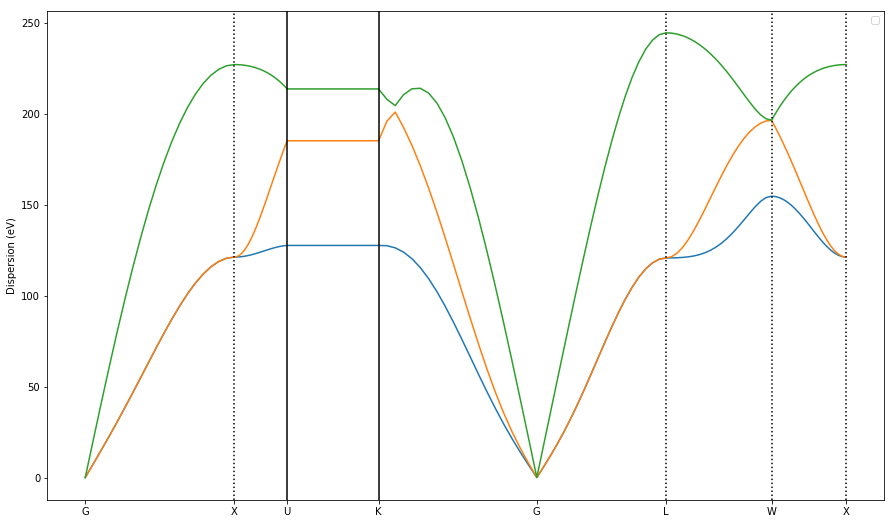

In [38]:
plt.rcParams['figure.figsize'] = (15.0, 9.0)

# Plot bands
for band in zip(*bands.get_bands()):
    plt.plot(bparams['kp_coordinates'], band,)

ticks = [(bparams['kp_coordinates'][xt], xl) 
         for xt, xl in bandskpoints.labels]
plt.xticks(zip(*ticks)[0], zip(*ticks)[1])

#vertical lines
plt.axvline(x=bparams['kp_coordinates'][38], color='k', linestyle='-')
plt.axvline(x=bparams['kp_coordinates'][39], color='k', linestyle='-')

plt.axvline(x=bparams['kp_coordinates'][19], color='k', linestyle=':')
plt.axvline(x=bparams['kp_coordinates'][77], color='k', linestyle=':')
plt.axvline(x=bparams['kp_coordinates'][96], color='k', linestyle=':')
plt.axvline(x=bparams['kp_coordinates'][115], color='k', linestyle=':')

#plt.axis([0.0, 3.34, -30.0, 25.0])  # rescale
plt.ylabel("Dispersion (eV)")
plt.legend()

plt.show()